# Implementation of Benchmark Problems

from https://benchmarks.sciml.ai/html/NonStiffSDE/BasicSDEWeakWorkPrecision.html
and https://benchmarks.sciml.ai/html/NonStiffSDE/BasicSDEWorkPrecision.html

In [1]:
import torch
from torch import tensor
from math import sqrt, tan
from time import time
import json
from matplotlib import pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive/')

base_folder = '..'  # 'drive/MyDrive/MA_Implementation'
import sys
sys.path.append(base_folder)
from RoughPaths import *
from RDEs import *
from ExamplePaths import *

In [2]:
def weak_error(approx_sol, exact_sol):
    return (approx_sol.mean(dim=0) - exact_sol.mean(dim=0)).abs()

def strong_error(approx_sol, exact_sol):
    return (approx_sol - exact_sol).abs().mean(dim=0)

In [3]:
def time_error_tradeoff(Ns, mu, f, f_prime, x0, path, T, correct_solution, d=1, eval_points=100, device='cpu'):
    sols = {}
    for N in Ns:
        del_t_max = T/N
        print(f"N={N}", end='\t')
        sol = RDESolution(mu, f, 1, path, f_prime, starting_point=x0, delta_t_max=del_t_max, device=device)
        start_sample = time()
        for i in range(N+1):
            path(i/N*T)
        end_sample = time()
        print(f"sampled path in {end_sample - start_sample:.2f}s", end='\t')
        start = time()
        sol(T, show_progress=False)
        end = time()
        print(f"solution calculated in {end - start:.2f}s")
        errors_along_path = []
        for i in range(eval_points):
            u = (i+1)/eval_points * T
            approx_sol = sol(u)
            exact_sol = correct_solution(u)
            e_w = weak_error(approx_sol, exact_sol).item()
            e_s = strong_error(approx_sol, exact_sol).item()
            errors_along_path.append((e_w, e_s))
        
        sols[N] = (end-start, sum(v[0] for v in errors_along_path)/eval_points, sum(v[1] for v in errors_along_path)/eval_points, end_sample - start_sample)
        path.reset()
    return sols

def plot_tradeoff(sols, t_per_run=False):
    fig, ax = plt.subplots(2, figsize=(10,15))
    ax[0].set_title(f"Weak Error {'per run' if t_per_run else ''}")
    ax[0].set_yscale("log")
    ax[0].set_ylabel("t [s]")
    ax[0].set_xlabel("Weak Error")
    ax[0].set_xscale("log")
    ax[1].set_title(f"Strong Error {'per run' if t_per_run else ''}")
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_ylabel("t [s]")
    ax[1].set_xlabel("Strong Error")
    
    for batch_size in sols:
        ax[0].plot([v[1] for v in sols[batch_size].values()], [v[0] if not t_per_run else v[0]/batch_size for v in sols[batch_size].values()], marker='o', label=f"batch size {batch_size}")
        ax[1].plot([v[2] for v in sols[batch_size].values()], [v[0] if not t_per_run else v[0]/batch_size for v in sols[batch_size].values()], marker='o', label=f"batch size {batch_size}")
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [4]:
# print(torch.cuda.get_device_name())
cuda0 = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print(cuda0)
device_name = torch.cuda.get_device_name() if torch.cuda.is_available() else 'AMD Ryzen 5 3600'

cpu


## Additive Noise Problem

SDE to solve is
\begin{equation} dX_{t}=\left(\frac{\beta}{\sqrt{1+t}}-\frac{1}{2\left(1+t\right)}X_{t}\right)dt+\frac{\alpha\beta}{\sqrt{1+t}}dW_{t},\thinspace\thinspace\thinspace X_{0}=\frac{1}{2},
\end{equation}
with $\alpha = \frac{1}{10}$, $\beta = \frac{1}{20}$. The correct solution is

\begin{equation}
	X_{t}=\frac{1}{\sqrt{1+t}}X_{0}+\frac{\beta}{\sqrt{1+t}}\left(t+\alpha W_{t}\right).
\end{equation}

In [5]:
alpha = .1
beta = .05
x0 = .5
T = 1.

def mu(X, t):
    # X of shape [b x 1]
    # t of shape 1
    return (beta/(1 + t).sqrt()).view(1, 1).repeat(batch_size, 1) - 1/(2 * (1 + t)) * X

def f(X, t):
    val = alpha*beta/(1 + t).sqrt()
    return val.repeat(batch_size).view(batch_size, 1, 1)

batch_sizes = [10, 100, 1000, 10000, 100000]
Ns = [100, 500, 1000, 5000, 10000]

def correct_solution(t):
    return 1/sqrt(1 + t) * x0 + beta/sqrt(1 + t) * (t + alpha * path(t)[0])

### How the Solution looks like:

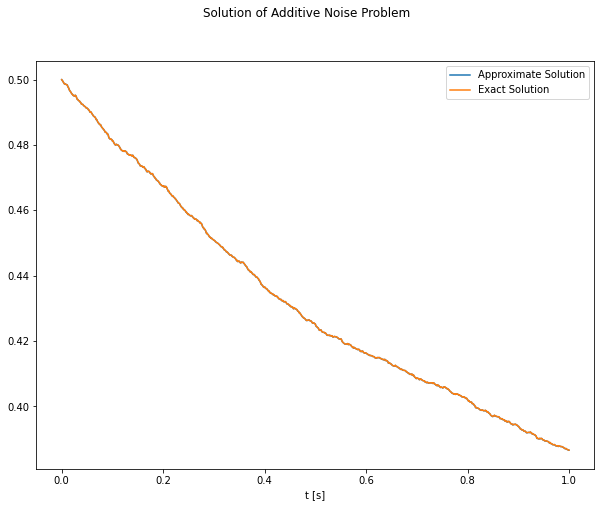

In [6]:
N = 1000
batch_size = 1
path = ItoBrownianRoughPath(1, 1)
f_prime = zeros(batch_size, 1, 1, 1)
sol = RDESolution(mu, f, 1, path, f_prime, starting_point=x0, delta_t_max=T/N)
eval_ts = [i/N for i in range(N+1)]

fig, ax = plt.subplots(figsize=(10,7.5))
fig.suptitle("Solution of Additive Noise Problem")
ax.set_xlabel("t [s]")
ax.plot(eval_ts, [sol(t)[0].item() for t in eval_ts], label="Approximate Solution")
ax.plot(eval_ts, [correct_solution(t).item() for t in eval_ts], label="Exact Solution")
ax.legend()
plt.show()

### Runtime & Error

In [7]:
batch_sizes

[10, 100, 1000, 10000, 100000]

batch_size=10
N=100	sampled path in 0.01s	solution calculated in 0.03s
N=500	sampled path in 0.03s	solution calculated in 0.16s
N=1000	sampled path in 0.07s	solution calculated in 0.32s
N=5000	sampled path in 0.47s	solution calculated in 2.86s
N=10000	sampled path in 1.18s	solution calculated in 8.29s
batch_size=100
N=100	sampled path in 0.01s	solution calculated in 0.03s
N=500	sampled path in 0.03s	solution calculated in 0.16s
N=1000	sampled path in 0.07s	solution calculated in 0.33s
N=5000	sampled path in 0.43s	solution calculated in 2.86s
N=10000	sampled path in 1.24s	solution calculated in 8.45s
batch_size=1000
N=100	sampled path in 0.01s	solution calculated in 0.03s
N=500	sampled path in 0.03s	solution calculated in 0.17s
N=1000	sampled path in 0.07s	solution calculated in 0.33s
N=5000	sampled path in 0.47s	solution calculated in 2.89s
N=10000	sampled path in 1.26s	solution calculated in 8.34s
batch_size=10000
N=100	sampled path in 0.01s	solution calculated in 0.04s
N=500	sampled 

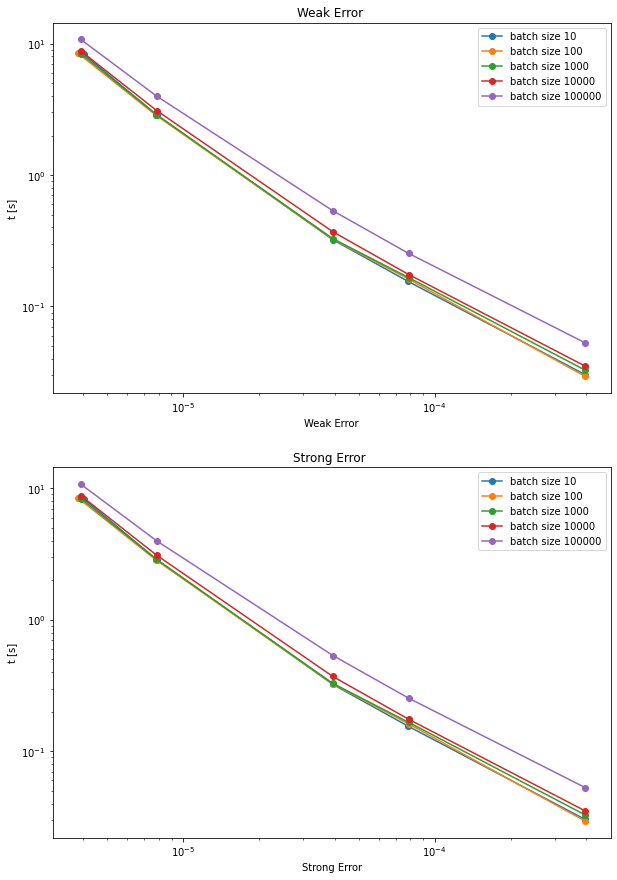

In [8]:
sols = {}
for batch_size in batch_sizes:
    f_prime = zeros(batch_size, 1, 1, 1, device=cuda0)
    path = ItoBrownianRoughPath(1, batch_size, device=cuda0)
    print(f"batch_size={batch_size}")
    sols[batch_size] = time_error_tradeoff(Ns, mu, f, f_prime, x0, path, T, correct_solution, d=1, device=cuda0)
plot_tradeoff(sols)

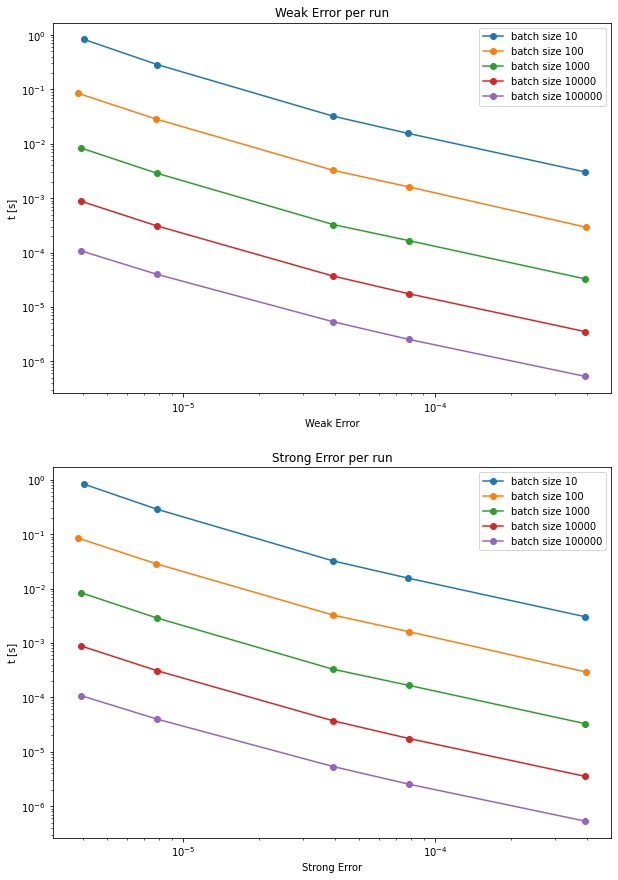

In [9]:
plot_tradeoff(sols, True)

In [10]:
with open(f"{base_folder}/models/additive_noise_problem_sols_{device_name.replace(' ', '_')}.json", "w+") as f:
    json.dump(sols, f)

## Scalar Noise Problem

SDE:
\begin{align*}
	dX_{t}=\alpha X_{t}dt+\beta X_{t}dW_{t},\thinspace\thinspace\thinspace X_{0}=\frac{1}{2},
\end{align*}
with $\alpha = \frac{1}{10}$, $\beta = \frac{1}{20}$. The correct solution is

\begin{align*}
	X_{t}=X_{0}e^{\left(\alpha-\frac{\beta^{2}}{2}\right)t+\beta W_{t}}.
\end{align*}

In [11]:
alpha = .1
beta = .05
x0 = .5
T = 1.

def mu(X, t):
    # X of shape [b x 1]
    # t of shape 1
    return alpha * X

def f(X, t):
    return beta * X.view(batch_size, 1, 1)

batch_sizes = [10, 100, 1000, 10000, 100000]
Ns = [100, 500, 1000, 5000, 10000]

def correct_solution(t):
    return x0 * ((alpha - beta**2/2) * t + beta * path(t)[0]).exp()

### Example Solution

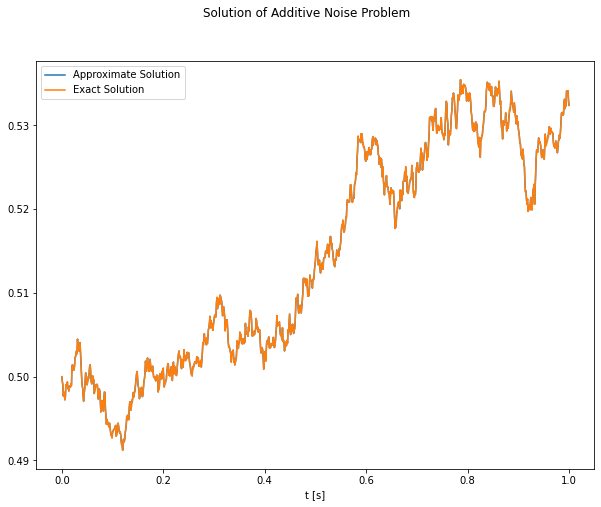

In [12]:
N = 1000
batch_size = 1
path = ItoBrownianRoughPath(1, 1, device=cuda0)
sol = RDESolution(mu, f, 1, path, "exact_no_grads", starting_point=x0, delta_t_max=T/N, device=cuda0)
eval_ts = [i/N for i in range(N+1)]

fig, ax = plt.subplots(figsize=(10,7.5))
fig.suptitle("Solution of Additive Noise Problem")
ax.set_xlabel("t [s]")
ax.plot(eval_ts, [sol(t)[0].item() for t in eval_ts], label="Approximate Solution")
ax.plot(eval_ts, [correct_solution(t).item() for t in eval_ts], label="Exact Solution")
ax.legend()
plt.show()

### Runtime & Errors

batch_size=10
N=100	sampled path in 0.01s	solution calculated in 0.02s
N=500	sampled path in 0.05s	solution calculated in 0.13s
N=1000	sampled path in 0.06s	solution calculated in 0.26s
N=5000	sampled path in 0.44s	solution calculated in 2.54s
N=10000	sampled path in 1.14s	solution calculated in 7.82s
batch_size=100
N=100	sampled path in 0.01s	solution calculated in 0.03s
N=500	sampled path in 0.03s	solution calculated in 0.13s
N=1000	sampled path in 0.07s	solution calculated in 0.27s
N=5000	sampled path in 0.53s	solution calculated in 2.61s
N=10000	sampled path in 1.20s	solution calculated in 7.96s
batch_size=1000
N=100	sampled path in 0.01s	solution calculated in 0.02s
N=500	sampled path in 0.03s	solution calculated in 0.13s
N=1000	sampled path in 0.07s	solution calculated in 0.27s
N=5000	sampled path in 0.48s	solution calculated in 2.60s
N=10000	sampled path in 1.23s	solution calculated in 7.92s
batch_size=10000
N=100	sampled path in 0.01s	solution calculated in 0.03s
N=500	sampled 

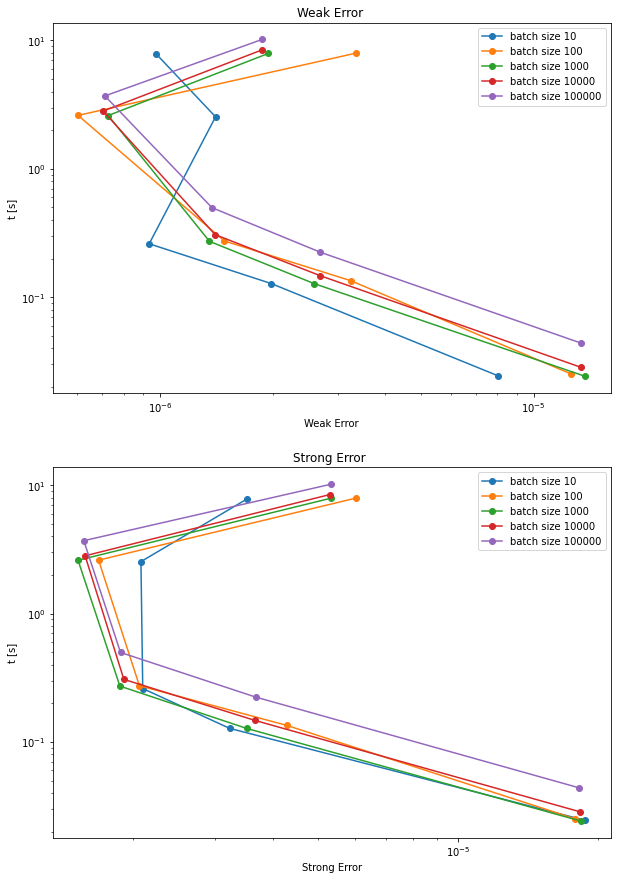

In [13]:
sols = {}
for batch_size in batch_sizes:
    f_prime = beta * ones(batch_size, 1, 1, 1, device=cuda0)
    path = ItoBrownianRoughPath(1, batch_size, device=cuda0)
    print(f"batch_size={batch_size}")
    sols[batch_size] = time_error_tradeoff(Ns, mu, f, f_prime, x0, path, T, correct_solution, d=1, device=cuda0)
plot_tradeoff(sols)

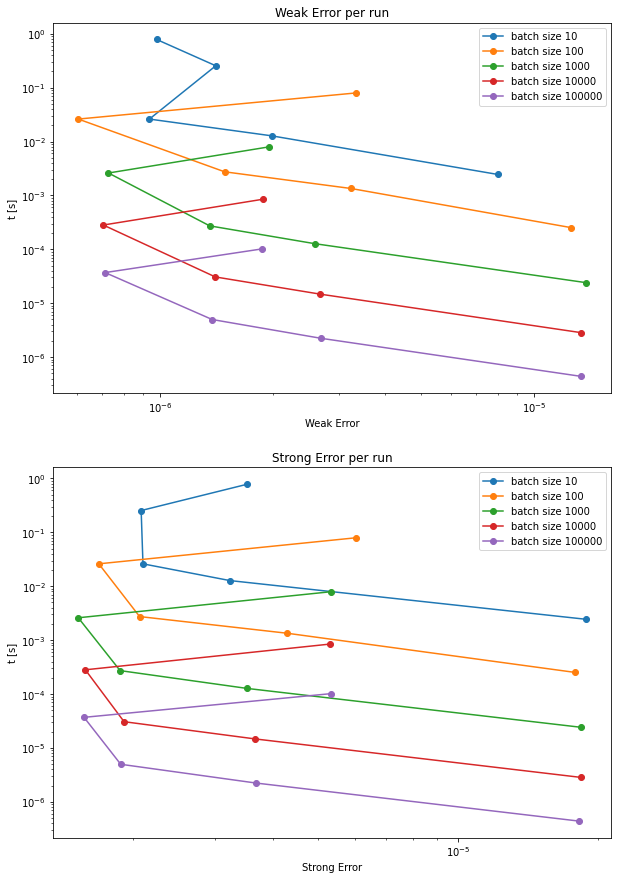

In [14]:
plot_tradeoff(sols, True)

In [15]:
with open(f"{base_folder}/models/scalar_noise_problem_sols_{device_name.replace(' ', '_')}.json", "w+") as f:
    json.dump(sols, f)

## Scalar Wave SDE

SDE:
\begin{align*}
	dX_{t}=-\left(\frac{1}{10}\right)^{2}\sin\left(X_{t}\right)\cos^{3}\left(X_{t}\right)dt+\frac{1}{10}\cos^{2}\left(X_{t}\right)dW_{t},\thinspace\thinspace\thinspace X_{0}=\frac{1}{2}.
\end{align*}
The correct solution is

\begin{align*}
	X_{t}=\arctan\left(\frac{1}{10}W_{t}+\tan\left(X_{0}\right)\right).
\end{align*}

In [16]:
alpha = .1
x0 = .5
T = 1.

def mu(X, t):
    # X of shape [b x 1]
    # t of shape 1
    return (- alpha**2 * X.sin() * X.cos().pow(3)).view(batch_size, 1)

def f(X, t):
    return alpha * X.cos().square().view(batch_size, 1, 1)

batch_sizes = [10, 100, 1000, 10000, 100000]
Ns = [100, 500, 1000, 5000, 10000]

def correct_solution(t):
    return (alpha * path(t)[0] + tan(x0)).arctan()

def f_prime(X, t):
    return (2 * alpha * X.sin() * X.cos()).view(batch_size, 1, 1, 1)

### Example Solution

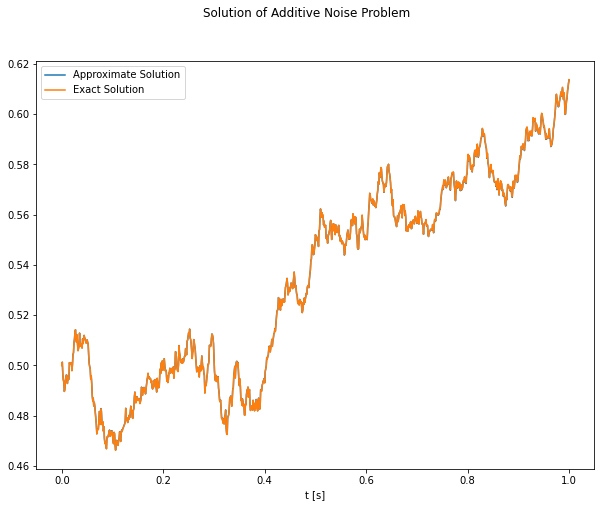

In [17]:
N = 1000
batch_size = 1
path = ItoBrownianRoughPath(1, 1, device=cuda0)
sol = RDESolution(mu, f, 1, path, f_prime, starting_point=x0, delta_t_max=T/N, device=cuda0)
eval_ts = [i/N for i in range(N+1)]

fig, ax = plt.subplots(figsize=(10,7.5))
fig.suptitle("Solution of Additive Noise Problem")
ax.set_xlabel("t [s]")
ax.plot(eval_ts, [sol(t)[0].item() for t in eval_ts], label="Approximate Solution")
ax.plot(eval_ts, [correct_solution(t).item() for t in eval_ts], label="Exact Solution")
ax.legend()
plt.show()

### Runtime & Errors

batch_size=10
N=100	sampled path in 0.01s	solution calculated in 0.02s
N=500	sampled path in 0.03s	solution calculated in 0.11s
N=1000	sampled path in 0.07s	solution calculated in 0.23s
N=5000	sampled path in 0.46s	solution calculated in 2.37s
N=10000	sampled path in 1.21s	solution calculated in 7.38s
batch_size=100
N=100	sampled path in 0.01s	solution calculated in 0.02s
N=500	sampled path in 0.03s	solution calculated in 0.11s
N=1000	sampled path in 0.07s	solution calculated in 0.24s
N=5000	sampled path in 0.47s	solution calculated in 2.51s
N=10000	sampled path in 1.22s	solution calculated in 7.53s
batch_size=1000
N=100	sampled path in 0.01s	solution calculated in 0.02s
N=500	sampled path in 0.04s	solution calculated in 0.12s
N=1000	sampled path in 0.08s	solution calculated in 0.26s
N=5000	sampled path in 0.50s	solution calculated in 2.53s
N=10000	sampled path in 1.31s	solution calculated in 7.68s
batch_size=10000
N=100	sampled path in 0.01s	solution calculated in 0.03s
N=500	sampled 

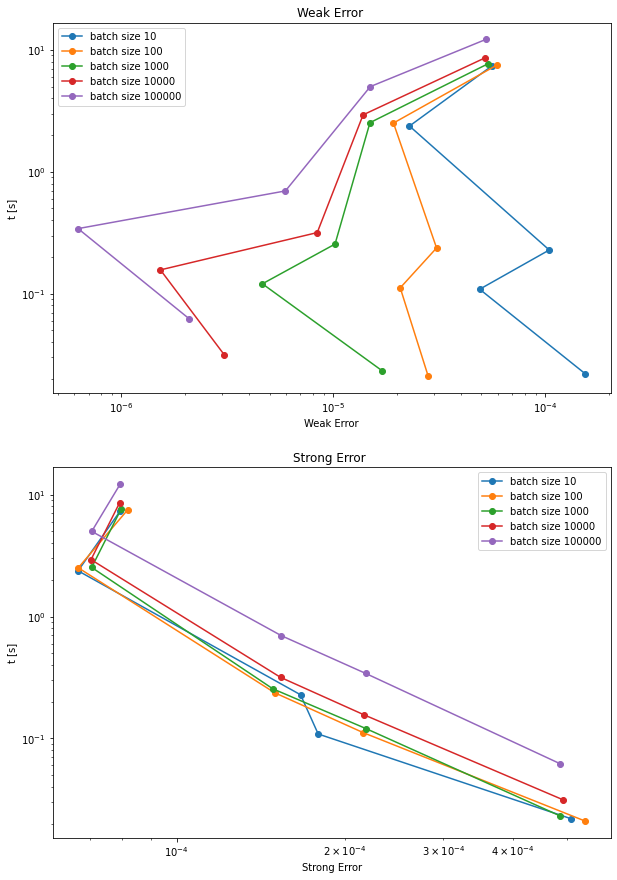

In [18]:
sols = {}
for batch_size in batch_sizes:
    path = ItoBrownianRoughPath(1, batch_size, device=cuda0)
    print(f"batch_size={batch_size}")
    sols[batch_size] = time_error_tradeoff(Ns, mu, f, f_prime, x0, path, T, correct_solution, d=1, device=cuda0)
plot_tradeoff(sols)

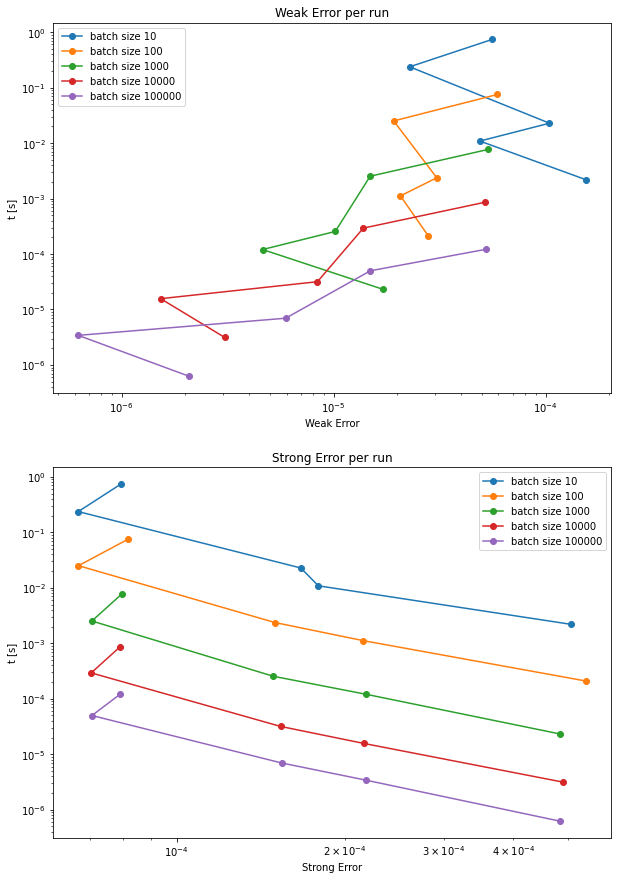

In [19]:
plot_tradeoff(sols, True)

In [20]:
with open(f"{base_folder}/models/scalar_wave_problem_sols_{device_name.replace(' ', '_')}.json", "w+") as f:
    json.dump(sols, f)